# 13 集成学习与随机森林

## 13.1 什么是集成学习
### 13.1 概述
#### 动画片举例
新世纪福音战士(EVA)->超级电脑MAGI（三贤者）->母亲的身份；科学家的身份；女性的身份
#### 生活中的集成学习
* 买东西找别人推荐？
* 病情确诊？

#### 机器学习中的集成学习
（kNN、逻辑回归、SVM、决策树、神经网络、贝叶斯）=>投票；少数服务多数 （Voting Classfier）

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets

X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)

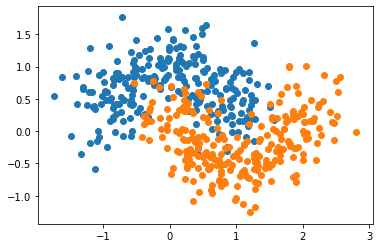

In [3]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
log_clf.score(X_test, y_test)

0.864

In [6]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.896

In [7]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=666)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

0.864

In [8]:
y_predict1 = log_clf.predict(X_test)
y_predict2 = svm_clf.predict(X_test)
y_predict3 = dt_clf.predict(X_test)

In [9]:
y_predict = np.array((y_predict1 + y_predict2 + y_predict3) >= 2, dtype='int')

In [10]:
y_predict[:10]

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [11]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict)

0.904

In [12]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()), 
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier(random_state=666))],
                             voting='hard')

In [13]:
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.904

## 13.2 Soft Voting
Voting Classfier
### 13.2.1 概述
* 更合理的投票，应该有权值
* 唱歌比赛的投票？

#### 距离
##### 数据
* 模型1 A-99%; B-1%
* 模型2 A-49%; B-51%
* 模型3 A-40%; B-60%
* 模型4 A-90%; B-10%
* 模型5 A-30%; B-70%
##### 分类
* Hard Voting：A-两票；B-三票
* Soft Voting：最终结果A
    * A-(0.99+0.49+0.4+0.9+0.3)/5=0.616 
    * B-(0.01+0.51+0.6+0.1+0.7)/5=0.384 

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from sklearn import datasets

X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)

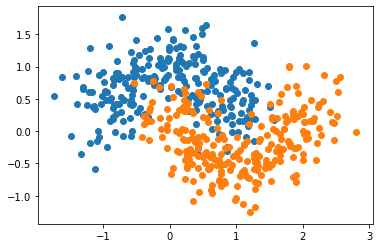

In [16]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### 使用Hard Voting Classfier

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()), 
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier(random_state=666))],
                             voting='hard')

In [19]:
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.904

#### 使用 Soft Voting Classifier

In [20]:
voting_clf2 = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()), 
    ('svm_clf', SVC(probability=True)),
    ('dt_clf', DecisionTreeClassifier(random_state=666))],
                             voting='soft')

In [21]:
voting_clf2.fit(X_train, y_train)
voting_clf2.score(X_test, y_test)

0.904

## 13.3 Bagging和Pasting

### 13.3.1概述
* 虽然有很多机器学习方法
* 但是从投票的角度看，仍然不够多

####
* 创建更多的子模型！集成更多的子模型的意见。
* 子模型之间不能一致！子模型之间要有差异性

#### 如何创建差异性
* 每个子模型只看样本数据的一部分
    * 例如：一共有500个样本数据；每个子模型只看100个样本数据
    * 每个子模型不需要太高的准确率
##### 距离
* 每个子模型不需要太高的准确率
    * 如果每个子模型只有51%的准确率
        * 如果我们只有1个子模型，整体准确率：51%
        * 如果我们只有3个子模型，整体准确率：$0.51^3 + C_3^2\cdot0.51^2\cdot0.49 = 51.5$
        * 如果我们只有500个子模型，整体准确率：$\sum_{i=251}^{500}C_{500}^i\cdot0.51^i\cdot0.49^{500-i} = 65.6\% $
    * 如果每个子模型只有60%的准确率
        * 如果我们只有500个子模型，整体准确率：$\sum_{i=251}^{500}C_{500}^i\cdot0.6^i\cdot0.4^{500-i} = 99.999\% $
        
##### 示例
* 每个子模型只看样本数据的一部分。
* 取样：放回取样=>Bagging，不放回取样=>Pasting
    * Bagging更常用
* 统计学中，放回取样：bootstrap

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
from sklearn import datasets

X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)

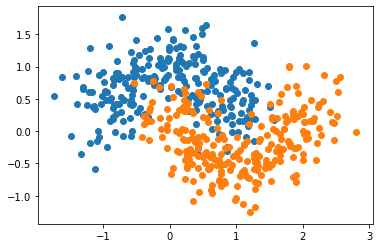

In [24]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

#### 使用Bagging

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=500, max_samples=100,
                           bootstrap=True)
bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_test, y_test)

0.92

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=5000, max_samples=100,
                           bootstrap=True)
bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_test, y_test)

0.912

## 13.4 OoB(Out-of-Bag）和关于Bagging的更多讨论

### 13.4.1 概述
#### OoB Out-of-Bag
* 放回取样导致一部分样本很有可能没有取到
* 平均大约有37%的样本没有取到
* 不适用测试数据集，而使用这部门没有取到的样本做测试/验证
* oob_score_

#### 更多讨论
* Bagging的思路极易并行化处理：n_jobs
* 针对特征进行随机采样：Random Subspaces
* 即针对样本，又针对特征进行随机采样：Random Patches

In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
from sklearn import datasets

X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42) 

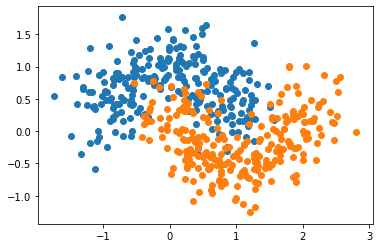

In [33]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100,
                               bootstrap=True, oob_score=True)
bagging_clf.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [35]:
bagging_clf.oob_score_

0.916

#### n_jobs

In [36]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100,
                               bootstrap=True, oob_score=True)
bagging_clf.fit(X, y)

CPU times: user 894 ms, sys: 26 ms, total: 920 ms
Wall time: 968 ms


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [37]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100,
                               bootstrap=True, oob_score=True,
                               n_jobs=-1)
bagging_clf.fit(X, y)

CPU times: user 273 ms, sys: 61.9 ms, total: 334 ms
Wall time: 2.62 s


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


#### bootstrap_features

In [38]:
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=500,
                               bootstrap=True, oob_score=True,
                               max_features=1, bootstrap_features=True)
random_subspaces_clf.fit(X, y)
random_subspaces_clf.oob_score_

0.826

In [39]:
random_patches_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100,
                               bootstrap=True, oob_score=True,
                               max_features=1, bootstrap_features=True)
random_patches_clf.fit(X, y)
random_patches_clf.oob_score_

0.858

## 13.5 随机森林和Extra-Trees
### 13.5.1 概述
#### 随机森林
* Bagging、Base Estimator：Decision Tree
* 决策树在节点划分上，在随机的特征子集上寻找最优划分特征

#### Extra-Trees
* 决策树在节点划分上，使用随机的特征和随机的阈值
* 提供额外的随机性，抑制过拟合，当增大了bias
* 更快的训练速度

In [40]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
from sklearn import datasets

X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=666)

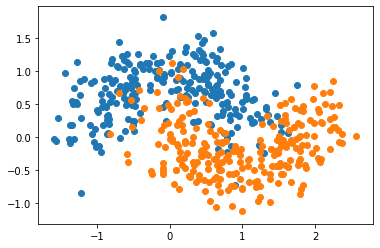

In [42]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=666, n_jobs=-1)
rf_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=666, verbose=0,
                       warm_start=False)

In [44]:
rf_clf.oob_score_

0.892

In [45]:
rf_clf2 = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, oob_score=True, random_state=666, n_jobs=-1)
rf_clf2.fit(X, y)
rf_clf2.oob_score_

0.906

#### Extra-Trees 随机森林拥有决策树和BaggingClassifier的所有参数

In [46]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500, bootstrap=True, oob_score=True, random_state=666, n_jobs=-1)
et_clf.fit(X, y)

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                     oob_score=True, random_state=666, verbose=0,
                     warm_start=False)

In [47]:
et_clf.oob_score_

0.892

#### 集成学习解决回归问题

In [48]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## 13.6 Ada Boosting和Gradient Boosting
### 13.6.1 概述
* 集成多个模型
* 每个模型都在尝试增强（Boosting）整体的效果

#### Ada Boosting

![](../image/rf6-1.png)
#### Gradient Boosting
* 训练一个模型m1，产生错误e1
* 针对e1训练第二个模型m2，产生错误e2
* 针对e2训练第三个模型m3，产生错误e3...
* 最终预测结果是：m1 + m2 + m3 + ...

![](../image/rf6-2.png)

In [49]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
from sklearn import datasets

X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=666) 

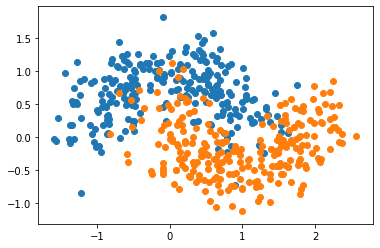

In [51]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

#### AdaBoosting

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=500)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [54]:
ada_clf.score(X_test, y_test)

0.872

#### Gradient Boosting

In [55]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=30)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [56]:
gb_clf.score(X_test, y_test)

0.904

#### Boosting 解决回归问题

In [57]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

## 13.7 Stacking
### 13.7.1 概述
![](../image/rf7-1.png)
![](../image/rf7-2.png)
![](../image/rf7-3.png)